Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 8 # 8,4
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data/sr/zebra_GT.png'

# Load image and baselines

HR and LR resolutions: (576, 384), (72, 48)


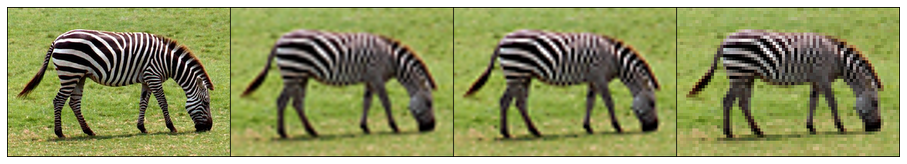

PSNR bicubic: 18.5498   PSNR nearest: 17.6935


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        compare_psnr(imgs['HR_np'], imgs['bicubic_np']), 
                                        compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

# Set up parameters and net

In [3]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [4]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
nchan=96
# net = get_net(input_depth, 'skip', pad,
#               skip_n33d=nchan, 
#               skip_n33u=nchan, 
#               skip_n11=4, 
#               num_scales=5,
#               upsample_mode='bilinear').type(dtype)

net = skip(
            input_depth, 3, 
            num_channels_down = [8, 16, 32, 64, 128], 
            num_channels_up   = [8, 16, 32, 64, 128],
            num_channels_skip = [0, 0, 0, 4, 4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

In [5]:
def _init_dcvx_parameters(net_to_dcvx):
    # parameters = [p for p in self.image_net.named_parameters()] + \
    #              [p for p in self.mask_net.named_parameters()]
    #     net_to_dcvx = [self.left_net,self.right_net]
    # if self._is_learning_ambient():
    #     net_to_dcvx.append(self.ambient_net)

    # set_trace()
    parameters = list()
    for net in net_to_dcvx:
        # for name, p  in net.named_parameters():
        #     print(name, end=' ')
        layer_id = 0
        # set_trace()
        for name, p  in net.named_parameters():
            layer_id +=1
            if "weight" in name and layer_id>7 and p.dim()>1:
                parameters.append(p)
                print(name)
    return parameters

def dcvx(parameters):
    neg_weight_reg  = 0.0 
    #parameters =self.dcvx_parameters
    for p in parameters:
        neg_weight_reg += torch.norm(p[p<0])
    return neg_weight_reg

dcvx_ = 1
dcvx_coeff= 0.00005
# if 'lib' in img_path:
#     dcvx_coeff= 0.00002
parameters = _init_dcvx_parameters([net])
stop_dcvx =0

1.7.1.1.1.weight
1.7.1.4.1.weight
1.7.1.7.1.1.1.weight
1.7.1.7.1.4.1.weight
1.7.1.7.1.7.1.0.1.1.weight
1.7.1.7.1.7.1.1.1.1.weight
1.7.1.7.1.7.1.1.4.1.weight
1.7.1.7.1.7.1.1.7.1.0.1.1.weight
1.7.1.7.1.7.1.1.7.1.1.1.1.weight
1.7.1.7.1.7.1.1.7.1.1.4.1.weight
1.7.1.7.1.7.1.1.7.3.1.weight
1.7.1.7.1.7.1.1.7.6.1.weight
1.7.1.7.1.7.3.1.weight
1.7.1.7.1.7.6.1.weight
1.7.1.7.3.1.weight
1.7.1.7.6.1.weight
1.7.3.1.weight
1.7.6.1.weight
3.1.weight
6.1.weight
9.1.weight


# Define closure and optimize

In [6]:
def closure():
    global i, net_input,  dcvx_, stop_dcvx, dcvx_coeff
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
    if dcvx_ and not stop_dcvx:
        dcvx_loss = dcvx(parameters)*dcvx_coeff
        if i%50==0:
            print("dcvx_loss:"+str(dcvx_loss.data.cpu())+ " total_loss:"+str(total_loss.data.cpu()))
            if dcvx_loss.data.cpu()> total_loss.data.cpu():
                dcvx_coeff = dcvx_coeff*0.25
                #stop_dcvx = 1
        #total_loss += dcvx_loss
            
        total_loss += dcvx_loss
        total_loss.backward(retain_graph=True)
    else:
        total_loss.backward()
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 200 == 0:
        out_HR_np = torch_to_np(out_HR)
        #plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)
        plot_image_grid([np.clip(out_HR_np, 0, 1)], factor=13, nrow=1)

    i += 1
    
    return total_loss

Starting optimization with ADAM


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


dcvx_loss:tensor(0.0026) total_loss:tensor(0.0548)


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


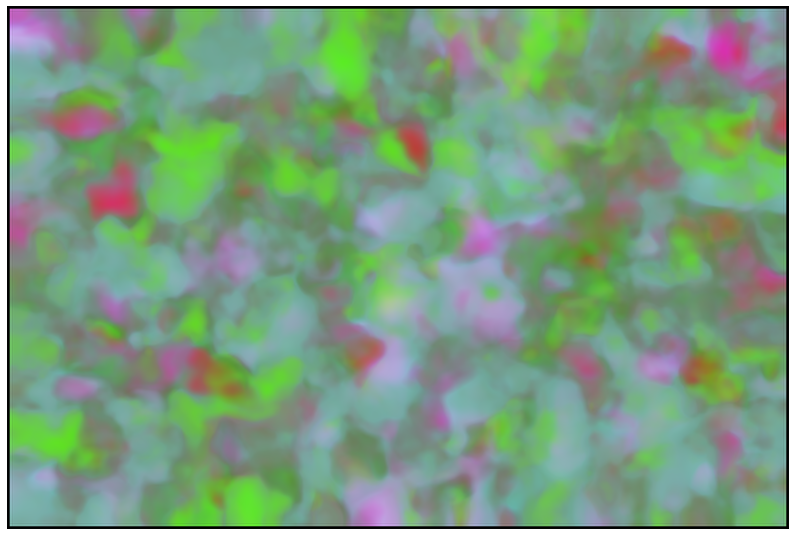

dcvx_loss:tensor(0.0058) total_loss:tensor(0.0222) 
dcvx_loss:tensor(0.0056) total_loss:tensor(0.0176) 
dcvx_loss:tensor(0.0053) total_loss:tensor(0.0147)  
dcvx_loss:tensor(0.0050) total_loss:tensor(0.0137) 


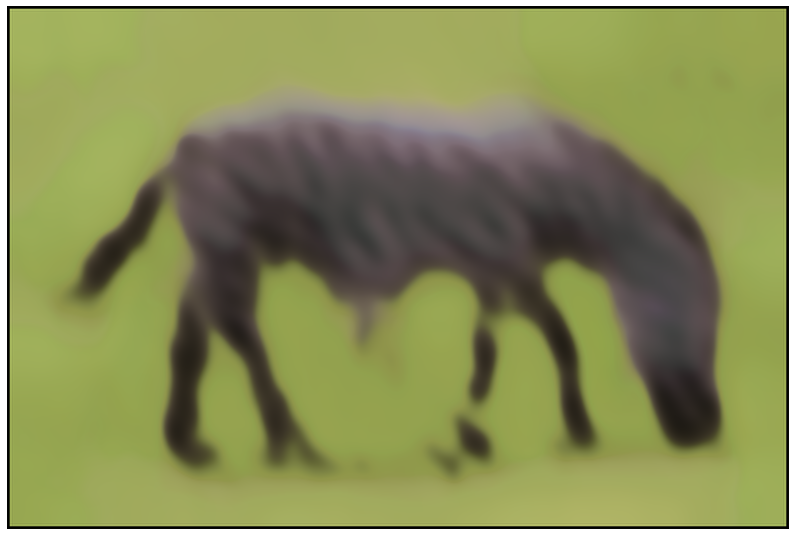

dcvx_loss:tensor(0.0048) total_loss:tensor(0.0117) 
dcvx_loss:tensor(0.0046) total_loss:tensor(0.0096) 
dcvx_loss:tensor(0.0044) total_loss:tensor(0.0067)  
dcvx_loss:tensor(0.0041) total_loss:tensor(0.0062) 


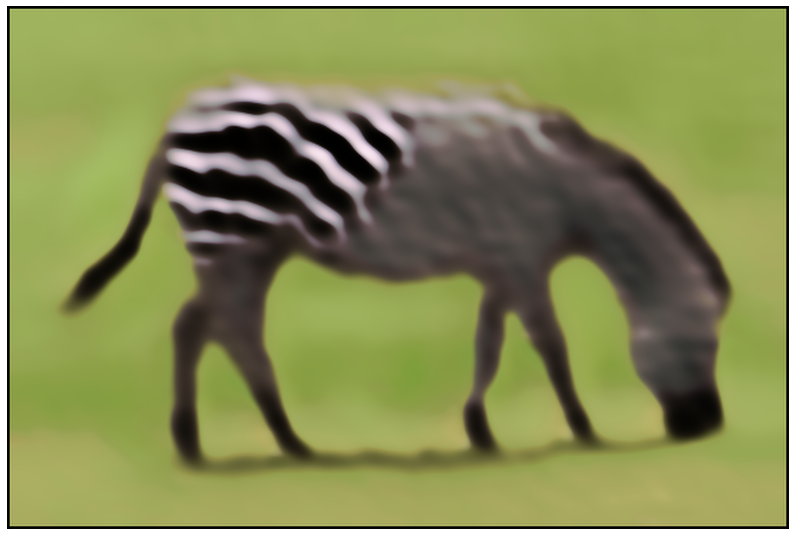

dcvx_loss:tensor(0.0038) total_loss:tensor(0.0052)   
dcvx_loss:tensor(0.0035) total_loss:tensor(0.0048) 
dcvx_loss:tensor(0.0033) total_loss:tensor(0.0043) 
dcvx_loss:tensor(0.0031) total_loss:tensor(0.0035) 


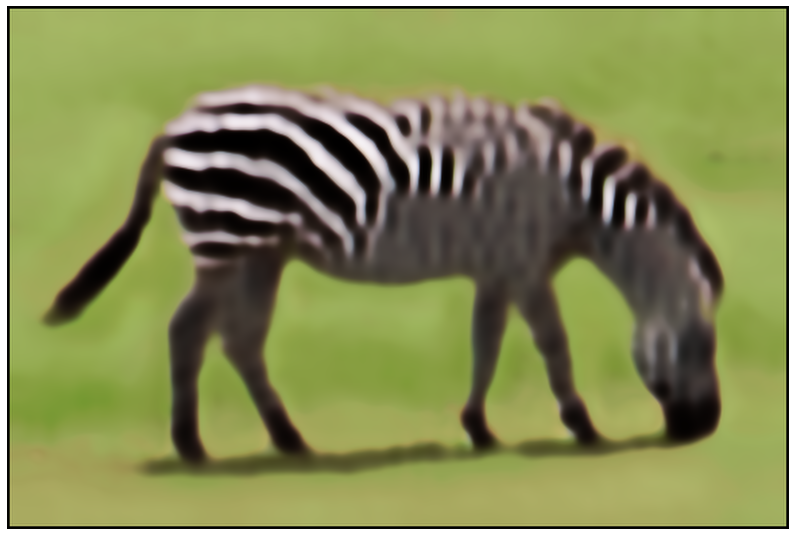

dcvx_loss:tensor(0.0028) total_loss:tensor(0.0027) 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0024) 
dcvx_loss:tensor(0.0008) total_loss:tensor(0.0019)  
dcvx_loss:tensor(0.0008) total_loss:tensor(0.0018) 


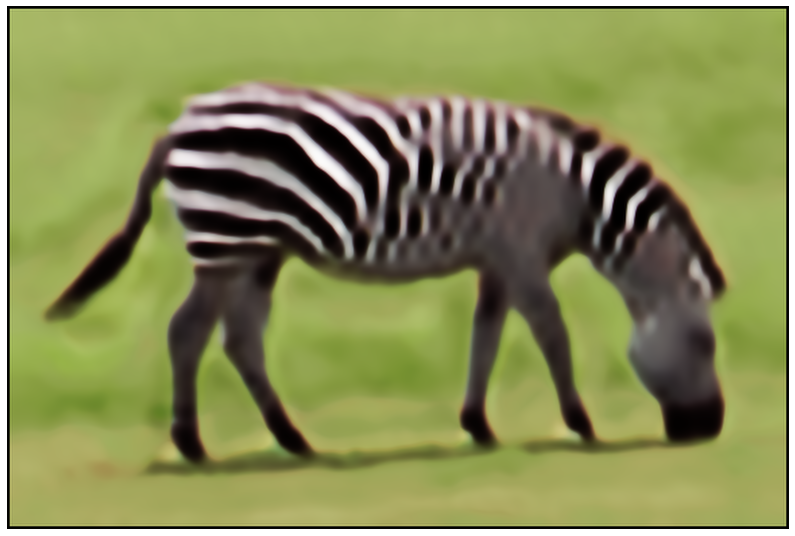

dcvx_loss:tensor(0.0008) total_loss:tensor(0.0017) 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0015) 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0014) 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0013) 


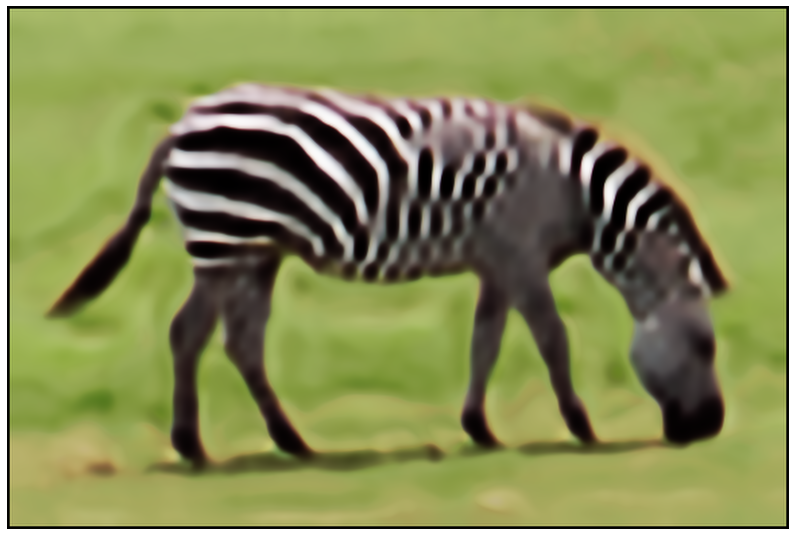

dcvx_loss:tensor(0.0007) total_loss:tensor(0.0012)  
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0010) 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0011) 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0010)  


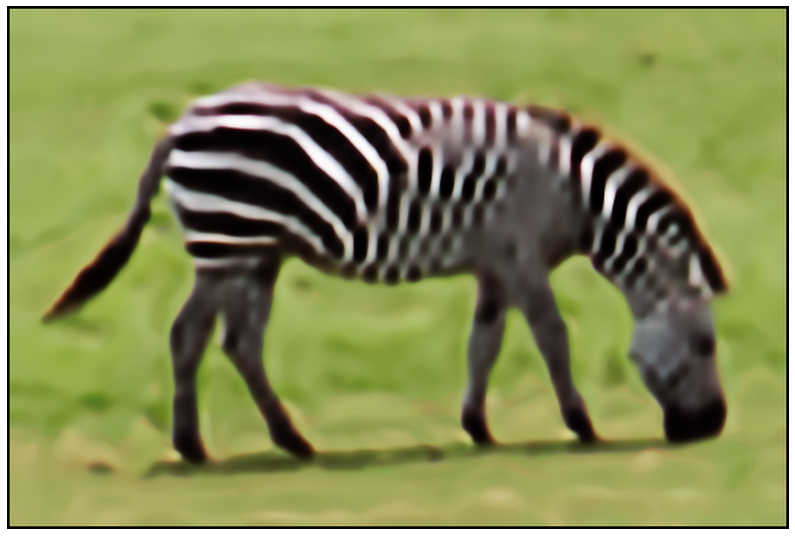

In [ ]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np']], factor=4, nrow=2);
# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([out_HR_np], factor=4, nrow=1);